In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from dython.nominal import associations
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings(action='ignore')


In [2]:
df = pd.read_csv('bikeSharing.csv', parse_dates=['dteday'], infer_datetime_format=True)

In [3]:
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2018-01-01,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,2018-02-01,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,2018-03-01,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,2018-04-01,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,2018-05-01,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


### Data Dict.
- instant: record index
	- dteday : date
	- season : season (1:spring, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2018, 1:2019)
	- mnth : month ( 1 to 12)
	- holiday : weather day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : temperature in Celsius
	- atemp: feeling temperature in Celsius
	- hum: humidity
	- windspeed: wind speed
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered
    

In [4]:
df.shape

(730, 16)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     730 non-null    int64         
 1   dteday      730 non-null    datetime64[ns]
 2   season      730 non-null    int64         
 3   yr          730 non-null    int64         
 4   mnth        730 non-null    int64         
 5   holiday     730 non-null    int64         
 6   weekday     730 non-null    int64         
 7   workingday  730 non-null    int64         
 8   weathersit  730 non-null    int64         
 9   temp        730 non-null    float64       
 10  atemp       730 non-null    float64       
 11  hum         730 non-null    float64       
 12  windspeed   730 non-null    float64       
 13  casual      730 non-null    int64         
 14  registered  730 non-null    int64         
 15  cnt         730 non-null    int64         
dtypes: datetime64[ns](1), floa

#### visualising rental trends over time

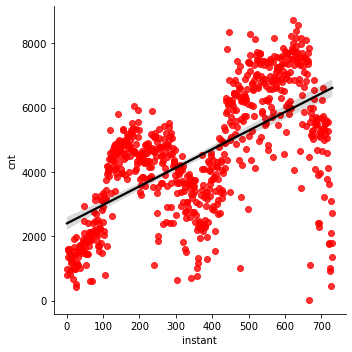

In [6]:
sns.lmplot(x='instant',y='cnt',data=df,fit_reg=True,scatter_kws={"color": "r"}, line_kws={"color": "black"}) 

In [7]:
df.drop('instant',axis = 1, inplace = True) ## we'll drop counter var. - instant

In [8]:
df.head(2)

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,2018-01-01,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2018-02-01,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801


#### replacing actual feature names from DD

In [9]:
df['season'] = df['season'].map({1:'spring', 2:'summer', 3:'fall', 4:'winter'})

## EDA

#### checking nomial features' distribution

In [10]:
df.value_counts(['season',])

season
fall      188
summer    184
spring    180
winter    178
dtype: int64

In [11]:
df.value_counts('weathersit')

weathersit
1    463
2    246
3     21
dtype: int64

#### We don't see any data for weathersit_4. so we can assume that it is a rare condition and exclude it from our analysis

In [31]:
df[df.workingday==0].weekday.value_counts()

6    105
0    105
1     15
5      2
4      2
3      1
2      1
Name: weekday, dtype: int64

- 0 = Sunday
- 1 = Monday
- 2 = Tuesday
- 3 = Wednesday
- 4 = Thursday
- 5 = Friday
- 6 = Saturday

#### Summary metrics

In [13]:
df[['temp','atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']].describe()

,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


### Missing Values imputation

#### we notice there are some 0 values in `humidity` feature, which seem incorrect. we'll have to explore this further

<AxesSubplot:ylabel='Frequency'>

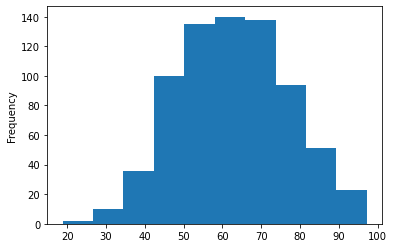

In [19]:
df.hum.plot.hist()

In [15]:
len(df[df.hum<1])

1

#### It's just one row and we can safely drop it.

In [16]:
df.shape

(730, 15)

In [17]:
df.drop(df[df.hum<1].index, axis=0, inplace=True)

In [18]:
df.shape

(729, 15)

#### visualising continious features

<AxesSubplot:>

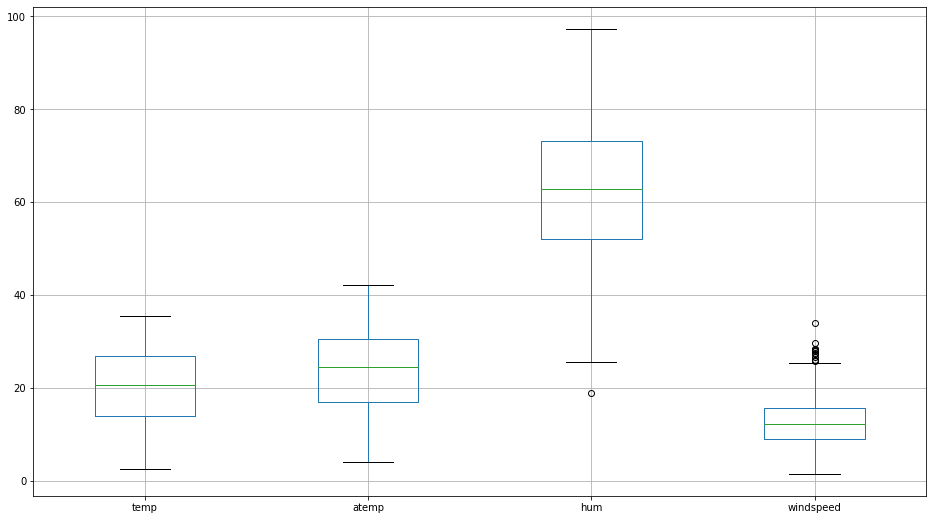

In [20]:
df[['temp','atemp', 'hum', 'windspeed',]].boxplot(figsize = (16,9))

<AxesSubplot:>

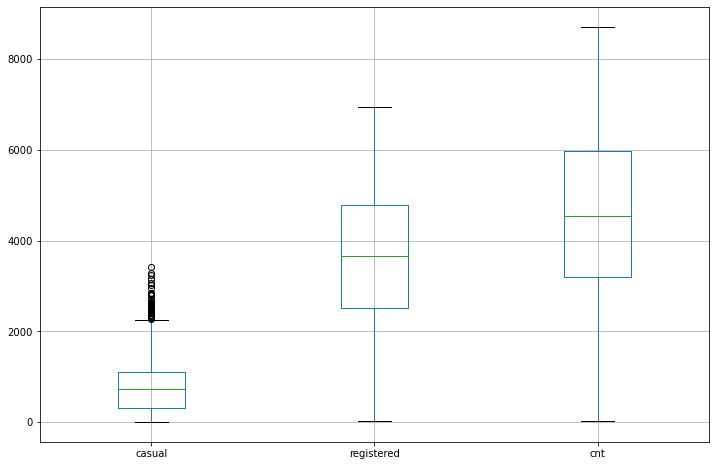

In [21]:
df[['casual', 'registered', 'cnt']].boxplot(figsize = (12,8))

#### visualising rental trends over time

<AxesSubplot:xlabel='dteday'>

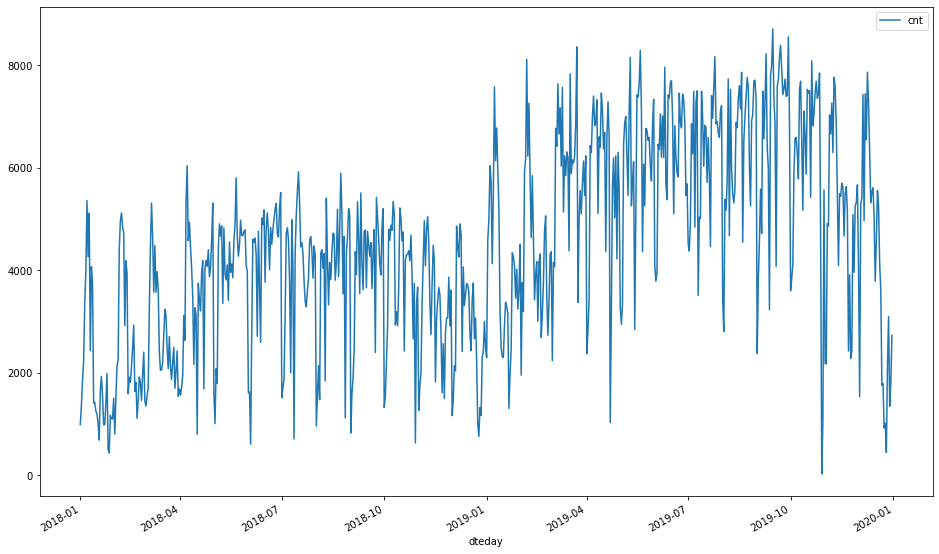

In [22]:
df.plot(kind = 'line' ,x = 'dteday', y = 'cnt', figsize=(16,10), )

<AxesSubplot:xlabel='dteday'>

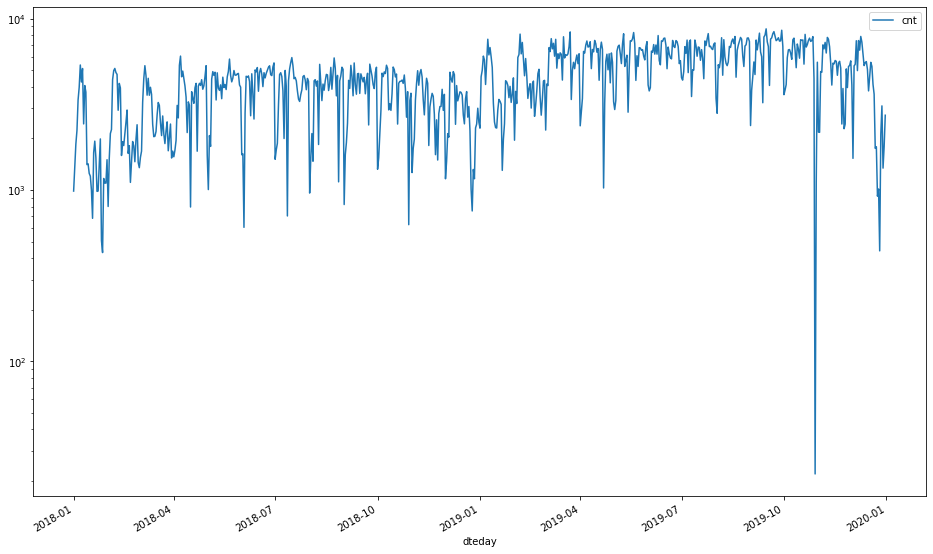

In [23]:
df.plot(kind = 'line' ,x = 'dteday', y = 'cnt', figsize=(16,10), logy=True)

<AxesSubplot:xlabel='dteday', ylabel='cnt'>

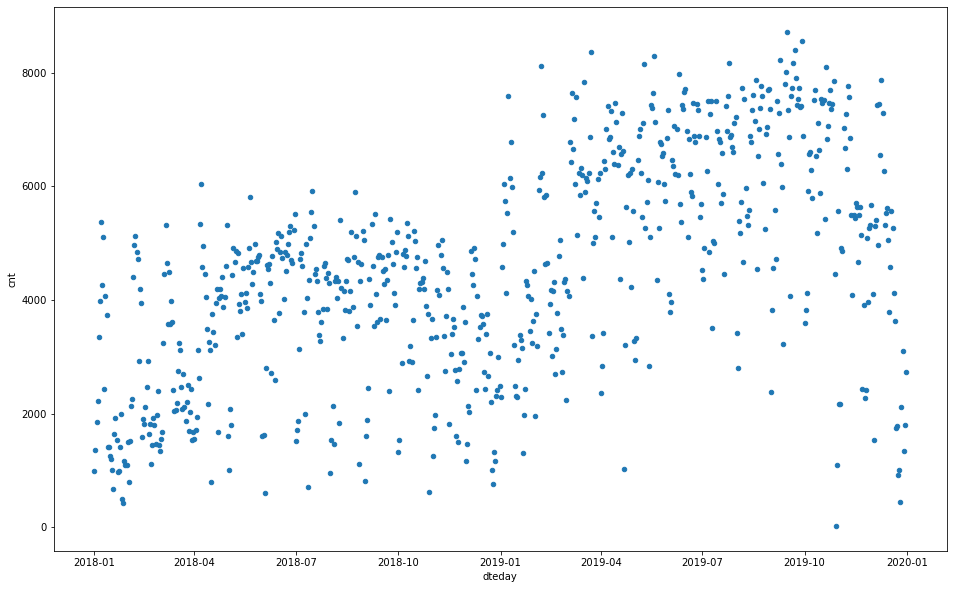

In [24]:
df.plot(kind = 'scatter' ,x = 'dteday', y = 'cnt', figsize=(16,10), logy=False)

#### visualising rental trends against weather related features

<AxesSubplot:xlabel='atemp', ylabel='cnt'>

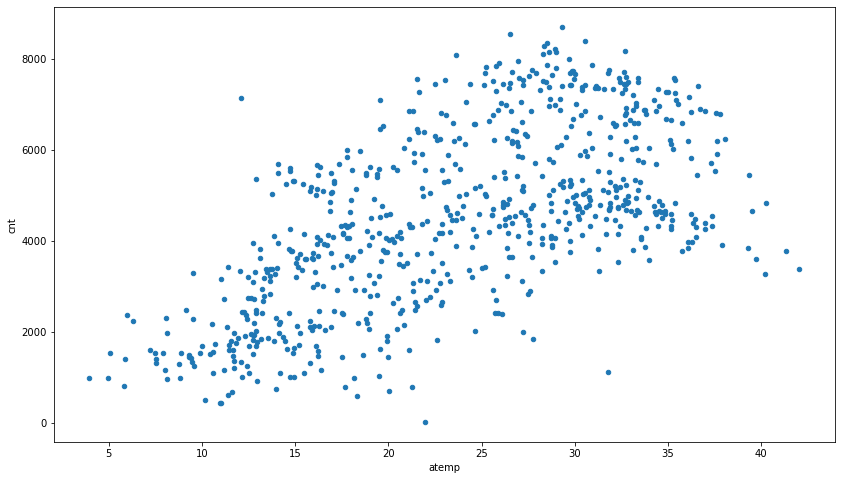

In [25]:
df.plot(kind = 'scatter', x = 'atemp', y= 'cnt', figsize = (14,8), )

<AxesSubplot:xlabel='windspeed', ylabel='cnt'>

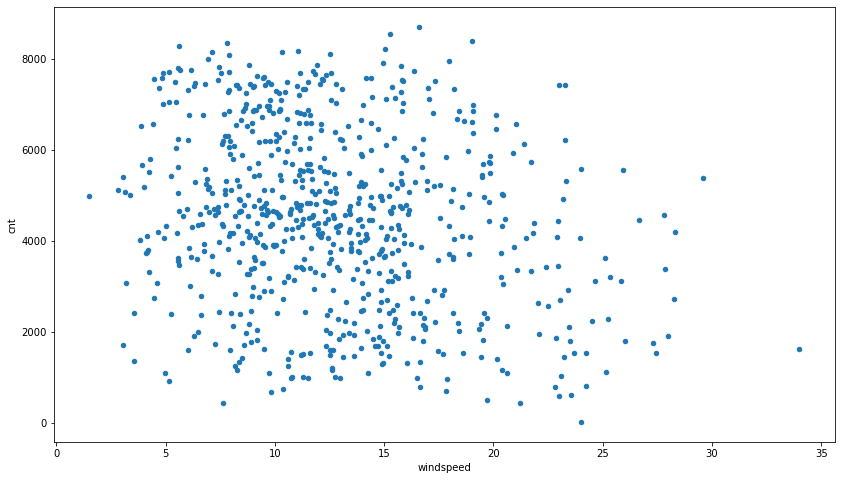

In [26]:
df.plot(kind = 'scatter', x = 'windspeed', y= 'cnt', figsize = (14,8), )

<AxesSubplot:xlabel='hum', ylabel='cnt'>

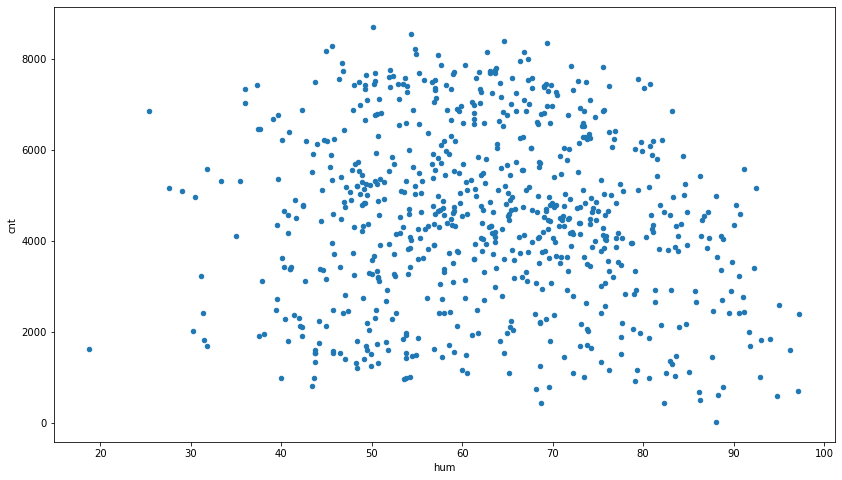

In [27]:
df.plot(kind = 'scatter', x = 'hum', y= 'cnt', figsize = (14,8), )

#### We see majority the rentals comes from users registered on the platform

<AxesSubplot:>

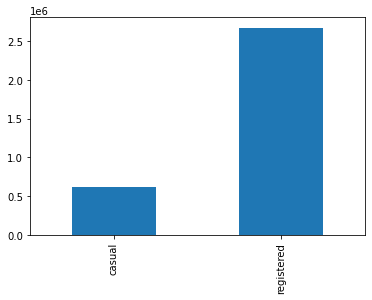

In [28]:
df[['casual','registered']].sum().plot(kind = 'bar',)

#### visualising sales trends over differnt seasons and weathersit

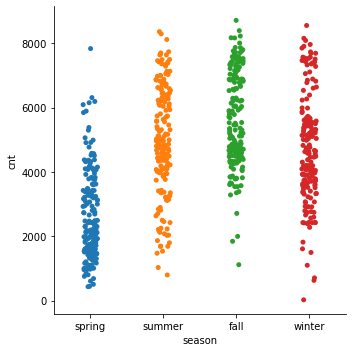

In [29]:
sns.catplot(x = 'season', y='cnt',data = df, jitter = True)

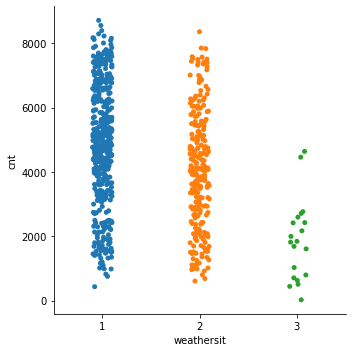

In [30]:
sns.catplot(x = 'weathersit', y='cnt',data = df, jitter = True)

#### renatls volume is impacted when it is snowing, heavily raining or foggy

#### visualising rental trends over different days of the week & months of year

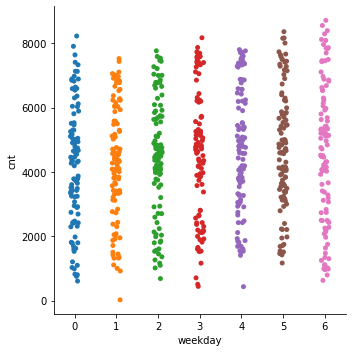

In [32]:
sns.catplot(x = 'weekday', y='cnt',data = df, jitter = True)

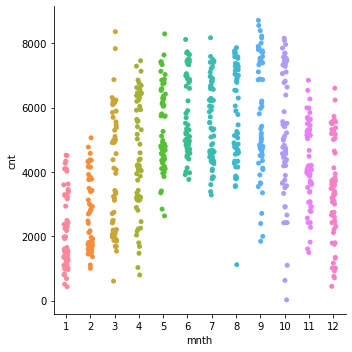

In [34]:
sns.catplot(x = 'mnth', y='cnt',data = df, jitter = True)

#### We can see that we did quite good after being 1 year in the business than in the very first year

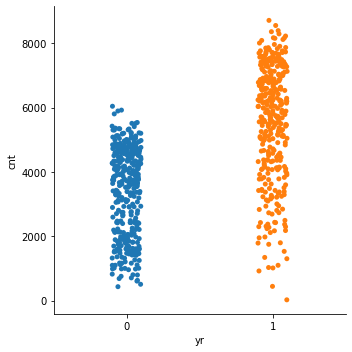

In [30]:
sns.catplot(x = 'yr', y='cnt',data = df, jitter = True)

#### visualising rental trends on holidays/ working days

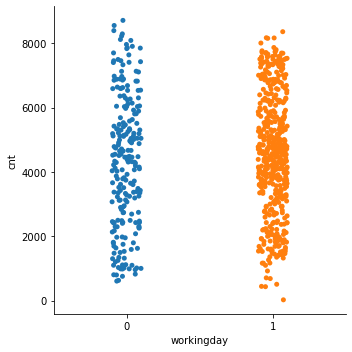

In [35]:
sns.catplot(x = 'workingday', y='cnt',data = df, jitter = True)

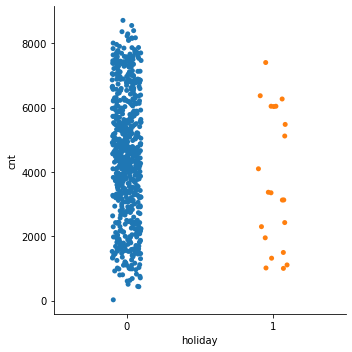

In [36]:
sns.catplot(x = 'holiday', y='cnt',data = df, jitter = True)

#### visualising rental trends over different days of the week and comparing if wi with when its a holiday

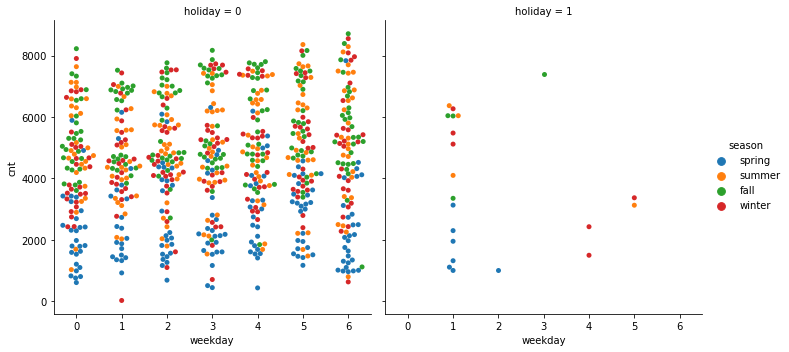

In [38]:
sns.catplot(x = 'weekday', y='cnt',data = df, kind = 'swarm', col = 'holiday', hue = 'season')

#### we can see that rentals drop sharply when its a holiday, more so if it is a holiday in spring season

#### visualising rental trends over different days of the week w.r.t. holiday

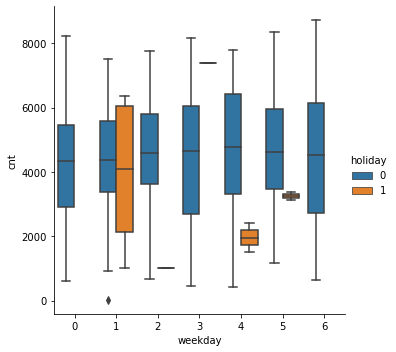

In [40]:
sns.catplot(x = 'weekday', y='cnt',data = df, kind = 'box', hue = 'holiday')

In [42]:
df.head(2)

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,2018-01-01,spring,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2018-02-01,spring,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801


### Calculating Pearsons correlation

In [44]:
df_corr = df.corr().apply(lambda s: s.apply(('{0:.5f}'.format))); df_corr

,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
yr,1.00000,-0.00140,0.00796,-0.00478,-0.00201,-0.04659,0.04803,0.04651,-0.12030,-0.01037,0.24930,0.59621,0.56894
mnth,-0.00140,1.00000,0.01868,0.01023,-0.00374,0.05009,0.21847,0.22587,0.22189,-0.20699,0.11976,0.29016,0.27634
holiday,0.00796,0.01868,1.00000,-0.10186,-0.25287,-0.03390,-0.02891,-0.03284,-0.01693,0.00648,0.05383,-0.10991,-0.06943
weekday,-0.00478,0.01023,-0.10186,1.00000,0.03535,0.02927,0.00023,-0.00717,-0.04994,0.01366,0.06085,0.05895,0.06912
workingday,-0.00201,-0.00374,-0.25287,0.03535,1.00000,0.05785,0.05404,0.05348,0.02770,-0.01954,-0.51716,0.30821,0.06462
weathersit,-0.04659,0.05009,-0.03390,0.02927,0.05785,1.00000,-0.11788,-0.11909,0.62011,0.03628,-0.24299,-0.25322,-0.29034
temp,0.04803,0.21847,-0.02891,0.00023,0.05404,-0.11788,1.00000,0.99169,0.12677,-0.15758,0.54243,0.53943,0.62732
atemp,0.04651,0.22587,-0.03284,-0.00717,0.05348,-0.11909,0.99169,1.00000,0.14012,-0.18333,0.54311,0.54377,0.63106
hum,-0.12030,0.22189,-0.01693,-0.04994,0.02770,0.62011,0.12677,0.14012,1.00000,-0.24638,-0.08350,-0.10283,-0.11251
windspeed,-0.01037,-0.20699,0.00648,0.01366,-0.01954,0.03628,-0.15758,-0.18333,-0.24638,1.00000,-0.16677,-0.21612,-0.23338


<AxesSubplot:>

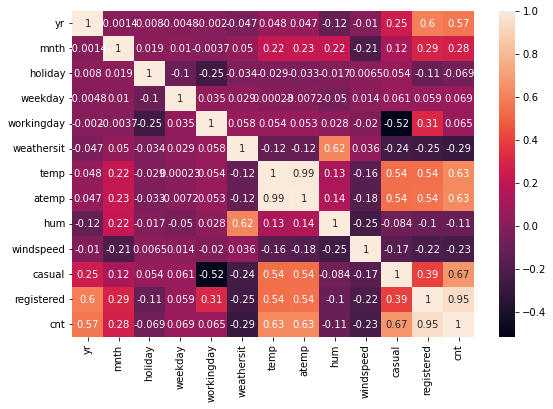

In [46]:
plt.figure(figsize=[9,6])
sns.heatmap(df_corr.astype(float),annot=True)

### We know  calculating Pearsons correlation is not advisable for nominal - nominal and nominal - continuous features. so we'll calculate them with differnt methods. namely:
- nominal - nominal = cramer
- numeric - numeric -  = pearson
- numeric - nominal = correlation_ratio

In [47]:
cat_vars = ['season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

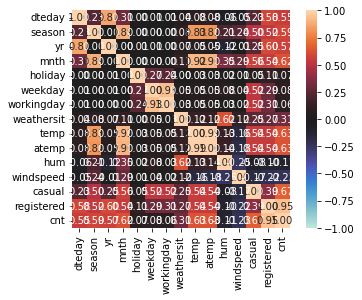

In [48]:
ass = associations(df, nominal_columns=cat_vars, numerical_columns=None, mark_columns=False, nom_nom_assoc='cramer', num_num_assoc='pearson', ax=None, figsize=None, annot=True, fmt='.2f', cmap=None, sv_color='silver', cbar=True, vmax=1.0, vmin=None, plot=True, compute_only=False, clustering=False, title=None, filename=None)


<AxesSubplot:>

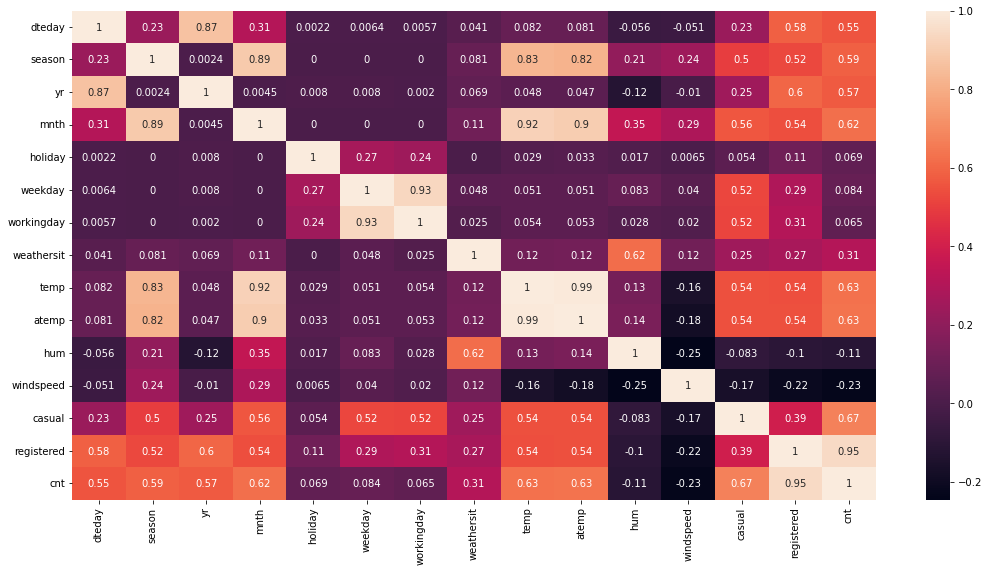

In [49]:
plt.figure(figsize=[18,9])
sns.heatmap(ass['corr'],annot=True)

#### We'll drop features with very high correlation in the next step

## Preparing the Data

#### We know that features `weekday` and `mnth` are categorical features with high level - 7 & 12 respectively.  We also know from previous tests, modelling all of them as it is would result in some levels turning out to be statstically insignificant. So we'll try to reduce the complexity by collapsing their levels in logical groups or eliminate them

#### we'll drop the features `casual`, `registered` since we do not want any data leakage in our modelling

In [50]:
df.drop(['casual', 'registered'], axis=1, inplace=True)

#### from the business understanding we've gained, we know that `atemp` or feels-like-temperature, is a derived variable calculated from `temperature`, `humidity` and `windspeed`. To begin with we'll drop `atemp` since it also has high correlation with `temp`.

In [51]:
df.drop('atemp', axis=1, inplace = True)

#### we can also drop `month` to further reduce the complexity of the model because we know that season is highly correlated to months and to the users of bike rentals season matters more than month

In [52]:
df.drop('mnth', axis=1, inplace = True)

#### we'll also drop the date column

In [53]:
df.drop('dteday', axis=1, inplace = True)

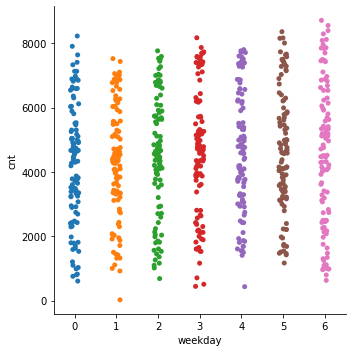

In [23]:
sns.catplot(x = 'weekday', y='cnt',data = df, jitter = True)

In [24]:
# df.drop('workingday', axis=1, inplace = True)

#### With the rental distribution over weekdays information, we can further reduce the complexity of our model by collapsing `weekday` into `is_weekend` binary dummy variable, where `is_weekday (is_weekend = 0)` will be our reference feature 

In [54]:
df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x in [0,6] else 0)

In [55]:
df.drop('weekday', axis= 1, inplace=True)

In [56]:
df.is_weekend.value_counts(1)

0    0.711934
1    0.288066
Name: is_weekend, dtype: float64

#### Given our EDA, we have 3 features relating to the day of the week. `weekday`. `workingday` `holiday`. We know that all three have high correlation. We'll keep all three for now and eliminate either `workinday` or `holiday` & `is_weekend`

In [57]:
df.head()

,season,yr,holiday,workingday,weathersit,temp,hum,windspeed,cnt,is_weekend
0,spring,0,0,0,2,14.110847,80.5833,10.749882,985,1
1,spring,0,0,0,2,14.902598,69.6087,16.652113,801,1
2,spring,0,0,1,1,8.050924,43.7273,16.636703,1349,0
3,spring,0,0,1,1,8.200000,59.0435,10.739832,1562,0
4,spring,0,0,1,1,9.305237,43.6957,12.522300,1600,0


### Feature encoding (for nominal features) - dummy variables

#### `is_weekend`, `workingday` and `holiday` are already in correct format. we need to convert `season` and `weathersit`

In [58]:
df.weathersit.value_counts()

1    463
2    246
3     20
Name: weathersit, dtype: int64

In [59]:
df.season.value_counts()

fall      188
summer    184
spring    179
winter    178
Name: season, dtype: int64

#### Since we see that weathersit_1 and season_fall are the most freequent, we'll make them our reference feature

In [60]:
df = pd.get_dummies(df, columns=['season', 'weathersit',], drop_first=True)

In [61]:
df.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,is_weekend,season_spring,season_summer,season_winter,weathersit_2,weathersit_3
0,0,0,0,14.110847,80.5833,10.749882,985,1,1,0,0,1,0
1,0,0,0,14.902598,69.6087,16.652113,801,1,1,0,0,1,0
2,0,0,1,8.050924,43.7273,16.636703,1349,0,1,0,0,0,0
3,0,0,1,8.200000,59.0435,10.739832,1562,0,1,0,0,0,0
4,0,0,1,9.305237,43.6957,12.522300,1600,0,1,0,0,0,0


In [62]:
df.shape

(729, 13)

### Train test split

In [63]:
df_n = df.copy()

In [65]:
df_train, df_test = train_test_split(df_n, train_size = 0.7, random_state = 27) # we'll do a 70 - 30 split

In [66]:
df_train.shape

(510, 13)

In [67]:
df_test.shape

(219, 13)

### Scaling numeric features

In [68]:
scaler = StandardScaler() ## We'll use standatd scaling over normalization as we would want to scale yr feature too, which we won't be able to do very well if we normalize

#### we won't be scaling target variable for interpretation reasons

In [69]:
numeric_feat = ['yr', 'temp', 'hum', 'windspeed',]
df_train[numeric_feat] = scaler.fit_transform(df_train[numeric_feat])

In [70]:
df_train.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,is_weekend,season_spring,season_summer,season_winter,weathersit_2,weathersit_3
211,-0.984435,0,0,1.712312,-1.105602,-0.306722,4302,1,0,0,0,0,0
283,-0.984435,0,1,0.383459,1.241650,-0.584466,4563,0,0,0,1,1,0
205,-0.984435,0,1,1.365050,0.871814,-1.250837,3840,0,0,0,0,0,0
382,1.015811,0,1,-1.079676,-1.374029,2.890511,3376,0,1,0,0,0,0
545,1.015811,0,0,1.485436,-0.243649,-0.354461,5687,1,0,0,0,0,0


### seperating x_train and y_train

In [71]:
y_train = df_train.pop('cnt')


In [72]:
x_train = df_train

In [73]:
x_train.head(2)

,yr,holiday,workingday,temp,hum,windspeed,is_weekend,season_spring,season_summer,season_winter,weathersit_2,weathersit_3
211,-0.984435,0,0,1.712312,-1.105602,-0.306722,1,0,0,0,0,0
283,-0.984435,0,1,0.383459,1.241650,-0.584466,0,0,0,1,1,0


In [74]:
y_train.head(2)

211    4302
283    4563
Name: cnt, dtype: int64

### Running RFE for quick feature importance overview

In [75]:
lr_rfe = LinearRegression()

In [76]:
lr_rfe.fit(x_train, y_train)

LinearRegression()

In [85]:
rfe = RFE(lr_rfe, n_features_to_select=1, verbose=1)

In [86]:
rfe = rfe.fit(x_train, y_train)

Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.


In [87]:
tuple(zip(x_train.columns,rfe.support_,(rfe.ranking_)))

(('yr', False, 3),
 ('holiday', False, 6),
 ('workingday', False, 11),
 ('temp', False, 4),
 ('hum', False, 10),
 ('windspeed', False, 9),
 ('is_weekend', False, 12),
 ('season_spring', False, 2),
 ('season_summer', False, 8),
 ('season_winter', False, 7),
 ('weathersit_2', False, 5),
 ('weathersit_3', True, 1))

## Modelling
#### our alpha value to accept a feature is set to - 0.05 - 5%

In [88]:
def get_vif(train_set): 
    vif = pd.DataFrame()
    X = train_set
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    print(vif)

In [89]:
import statsmodels.api as sm  

In [90]:
x_train_1 = x_train.copy()

In [91]:
x_train_1.drop('workingday',1, inplace = True) # building first model without workingday feature

/var/folders/z0/wbc1b27j3r5102_79kyb6hyr0000gn/T/ipykernel_23982/3056862471.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train_1.drop('workingday',1, inplace = True) # building first model without workingday feature


In [92]:
x_train_1 = sm.add_constant(x_train_1)

In [93]:
model1 = sm.OLS(y_train, x_train_1).fit()

In [94]:
print(model1.summary())


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     211.2
Date:                Wed, 15 Jun 2022   Prob (F-statistic):          1.40e-179
Time:                        21:06:05   Log-Likelihood:                -4131.8
No. Observations:                 510   AIC:                             8288.
Df Residuals:                     498   BIC:                             8338.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          4642.6175    112.112     41.411

In [95]:
get_vif(x_train_1)

         Features   VIF
0           const  9.82
7   season_spring  4.22
3            temp  3.27
9   season_winter  3.06
4             hum  2.10
8   season_summer  1.98
10   weathersit_2  1.66
11   weathersit_3  1.37
5       windspeed  1.20
1              yr  1.07
6      is_weekend  1.03
2         holiday  1.02


In [96]:
x_train_2 = x_train_1.copy()

In [97]:
x_train_2.drop('is_weekend', axis=1, inplace=True) # We'll drop is_weekend as it isn't stastically significant

In [98]:
# x_train_2 = sm.add_constant(x_train_2)

In [99]:
model2 = sm.OLS(y_train, x_train_2).fit()

In [100]:
print(model2.summary())


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     230.8
Date:                Wed, 15 Jun 2022   Prob (F-statistic):          5.49e-180
Time:                        21:07:41   Log-Likelihood:                -4133.7
No. Observations:                 510   AIC:                             8289.
Df Residuals:                     499   BIC:                             8336.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          4589.4004    108.889     42.147

In [228]:
get_vif(x_train_2)

        Features   VIF
0          const  8.69
7       season_3  4.47
3           temp  3.26
6       season_2  2.55
4            hum  2.10
8       season_4  1.87
9   weathersit_2  1.65
10  weathersit_3  1.37
5      windspeed  1.20
1             yr  1.07
2        holiday  1.00


### Model - 2 seems like a good model

In [102]:
x_train_3 = x_train_2.copy()

In [103]:
x_train_3.drop(['holiday'], axis=1, inplace=True) # dropping holiday to see the impact

In [104]:
model3 = sm.OLS(y_train, x_train_3).fit()

In [105]:
print(model3.summary())


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     252.4
Date:                Wed, 15 Jun 2022   Prob (F-statistic):          1.27e-179
Time:                        21:09:36   Log-Likelihood:                -4137.4
No. Observations:                 510   AIC:                             8295.
Df Residuals:                     500   BIC:                             8337.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          4581.7533    109.540     41.827

In [106]:
get_vif(x_train_3)

        Features   VIF
0          const  9.21
5  season_spring  4.21
2           temp  3.26
7  season_winter  3.06
3            hum  2.10
6  season_summer  1.98
8   weathersit_2  1.65
9   weathersit_3  1.37
4      windspeed  1.20
1             yr  1.07


### Model - 3 seems like a good model too

In [113]:
x_train_4 = x_train.copy()

In [114]:
x_train_4.head(2)

,yr,holiday,workingday,temp,hum,windspeed,is_weekend,season_spring,season_summer,season_winter,weathersit_2,weathersit_3
211,-0.984435,0,0,1.712312,-1.105602,-0.306722,1,0,0,0,0,0
283,-0.984435,0,1,0.383459,1.241650,-0.584466,0,0,0,1,1,0


#### Modelling including `workingday` and features `excluding holiday`, `is_weekend` which are highly colinear to it
#### we can understand the impact of `workingday` independently using this model

In [115]:
x_train_4.drop(['holiday', 'is_weekend'], axis=1, inplace=True)

In [116]:
x_train_4 = sm.add_constant(x_train_4)

In [117]:
model4 = sm.OLS(y_train, x_train_4).fit()

In [118]:
print(model4.summary())


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     230.2
Date:                Wed, 15 Jun 2022   Prob (F-statistic):          8.87e-180
Time:                        21:11:37   Log-Likelihood:                -4134.2
No. Observations:                 510   AIC:                             8290.
Df Residuals:                     499   BIC:                             8337.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          4454.2833    120.107     37.086

In [119]:
get_vif(x_train_4)

         Features    VIF
0           const  11.19
6   season_spring   4.21
3            temp   3.27
8   season_winter   3.06
4             hum   2.10
7   season_summer   1.98
9    weathersit_2   1.66
10   weathersit_3   1.37
5       windspeed   1.20
1              yr   1.07
2      workingday   1.02


#### using, workingday, is_weekend and holiday

In [98]:
x_train_5 = x_train.copy()

In [99]:
x_train_5 = sm.add_constant(x_train_5)

In [100]:
model5 = sm.OLS(y_train, x_train_5).fit()

In [101]:
print(model5.summary())


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     218.6
Date:                Wed, 15 Jun 2022   Prob (F-statistic):          1.80e-196
Time:                        19:09:19   Log-Likelihood:                -4745.0
No. Observations:                 583   AIC:                             9514.
Df Residuals:                     571   BIC:                             9566.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         2760.2808     95.411     28.930   

In [102]:
get_vif(x_train_5)

        Features   VIF
2        holiday   inf
3     workingday   inf
7     is_weekend   inf
9       season_3  4.87
4           temp  3.39
8       season_2  2.69
5            hum  2.05
10      season_4  1.97
11  weathersit_2  1.69
12  weathersit_3  1.39
6      windspeed  1.19
1             yr  1.03
0          const  0.00


/Users/rishabh/opt/miniconda3/envs/py39new/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/rishabh/opt/miniconda3/envs/py39new/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


#### Exactly as we had assumed, `workinday`, `is_weekend` and `holiday` are perfectly colinear and give an inf. VIF

###  Model Selection

#### If we were to deploy this model, we could have chosen model_3, which is the least complex and light weight model with only 9 features.
#### But since our goal is to interpret the independent features, we'll use model_2 as we think information about renatl trends when it is a `holiday` would be useful for the business teams

## Residual analysis

In [120]:
y_train_pred = model2.predict(x_train_2)

In [121]:
residual = y_train - y_train_pred

#### normallity test

/Users/rishabh/opt/miniconda3/envs/py39new/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

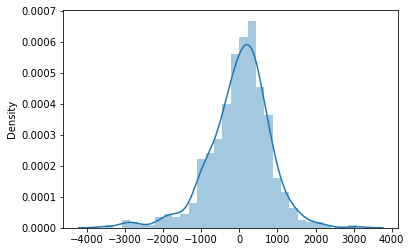

In [122]:
fig = plt.figure()
sns.distplot((residual), bins = 30)


#### Homoscedasticity test

/Users/rishabh/opt/miniconda3/envs/py39new/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='cnt'>

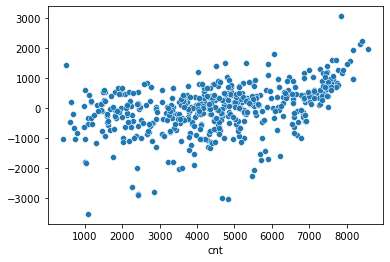

In [123]:
sns.scatterplot(y_train,residual)


/Users/rishabh/opt/miniconda3/envs/py39new/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Residual')

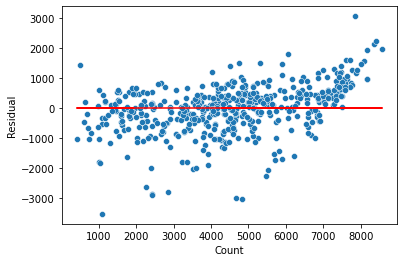

In [124]:
sns.scatterplot(y_train,residual)
plt.plot(y_train,(y_train - y_train), '-r')
plt.xlabel('Count')
plt.ylabel('Residual')


#### fundamental tests look good

## Model Evaluation

In [125]:
df_test.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,is_weekend,season_spring,season_summer,season_winter,weathersit_2,weathersit_3
130,0,0,1,22.242500,63.2917,8.083014,4182,0,0,1,0,0,0
407,1,0,0,5.227500,46.4583,27.417204,1529,1,1,0,0,0,0
497,1,0,0,25.112500,57.6250,15.082839,6118,1,0,1,0,0,0
197,0,0,0,29.485847,60.4167,16.417211,5302,1,0,0,0,0,0
121,0,0,1,22.515847,73.0000,12.291418,4401,0,0,1,0,1,0


In [126]:
df_test.drop(['workingday','is_weekend'],1, inplace = True) # dropping insignificant features from our test set 

/var/folders/z0/wbc1b27j3r5102_79kyb6hyr0000gn/T/ipykernel_23982/3430336035.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_test.drop(['workingday','is_weekend'],1, inplace = True) # dropping insignificant features from our test set


#### seperating target variable and applying scaling transformations on test set

In [127]:
y_test = df_test.pop('cnt')
x_test = df_test

In [128]:
x_test.head(2)

,yr,holiday,temp,hum,windspeed,season_spring,season_summer,season_winter,weathersit_2,weathersit_3
130,0,0,22.2425,63.2917,8.083014,0,1,0,0,0
407,1,0,5.2275,46.4583,27.417204,1,0,0,0,0


In [129]:
numeric_feat = ['yr', 'temp', 'hum', 'windspeed']
x_test[numeric_feat] = scaler.fit_transform(x_test[numeric_feat])

In [130]:
x_test.head(2)

,yr,holiday,temp,hum,windspeed,season_spring,season_summer,season_winter,weathersit_2,weathersit_3
130,-1.041976,0,0.269684,0.143183,-0.974455,0,1,0,0,0
407,0.959715,0,-1.915345,-1.051010,2.858276,1,0,0,0,0


In [131]:
x_test = sm.add_constant(x_test)

In [132]:
x_test.head(2)

,const,yr,holiday,temp,hum,windspeed,season_spring,season_summer,season_winter,weathersit_2,weathersit_3
130,1.0,-1.041976,0,0.269684,0.143183,-0.974455,0,1,0,0,0
407,1.0,0.959715,0,-1.915345,-1.051010,2.858276,1,0,0,0,0


In [133]:
y_test_pred = model2.predict(x_test)


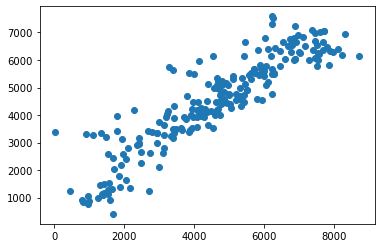

In [134]:
plt.scatter(y_test,y_test_pred)

In [136]:
def get_metrics(test, pred,k):
    r2 = r2_score(test, pred) 
    n = len(pred)
    adj_r2_score = 1 - ((1-r2)*(n-1)/(n-k-1))
    rmse = np.sqrt(mean_squared_error(test,pred))
    print(f"r-squared -- {r2}")
    print(f"adj. r-squared -- {r2}")
    print(f"rmse -- {rmse}")        

### Metrics on train set

In [138]:
get_metrics(y_train, y_train_pred, len(model2.params))

r-squared -- 0.8222089027072093
adj. r-squared -- 0.8222089027072093
rmse -- 801.3677179164567


In [139]:
get_metrics(y_test, y_test_pred, len(model2.params))

r-squared -- 0.8127088990160847
adj. r-squared -- 0.8127088990160847
rmse -- 864.797867362496


#### we can conclude our model is not over-fitting

#  Inferences/ Interpretations

In [141]:
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     230.8
Date:                Wed, 15 Jun 2022   Prob (F-statistic):          5.49e-180
Time:                        21:25:15   Log-Likelihood:                -4133.7
No. Observations:                 510   AIC:                             8289.
Df Residuals:                     499   BIC:                             8336.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          4589.4004    108.889     42.147

#### Reference variables for categorical feature

In [143]:
pd.DataFrame({'feature': ['holiday', 'season', 'weathersit'], 'reference': ['not_a_holiday', 'season_fall', 'weathersit_1']})

,feature,reference
0,holiday,not_a_holiday
1,season,season_fall
2,weathersit,weathersit_1


## Interpreting categorical features


##### weathersit explaination : 
	- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
	- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
	- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
	- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

### Weathersit - We can draw the following conclusions about `weathersit`

    - weathersit_3 - We see rentals go down by `1726` units during weathersit_3 as compared to weatherset_1 (reference), everything else being constant
    - weathersit_2 - We see rentals go down by `344` units during weathersit_2 as compared to weatherset_1 (refernce), everything else being constant

### Seasons -  We can draw the following conclusions about `season`:
- season_spring - We see that spring season has a negative impact on bike rentals
    - We see rentals go down by `635` units in spring season when compared to fall season (reference), everything else kept constant
- season_summer - We see that summer season has a positive impact on bike rentals
    - We see rentals go down by `262` units in spring season when compared to fall season (reference), everything else kept constant
- season_witer - We see that winter season has a positive impact on bike rentals
    - We see rentals go down by `696` units in spring season when compared to fall season (reference), everything else kept constant

### Holiday
- We see that public holidays cause a negative impact on bike rentals
    - We see that rentals go down by `596` units on holidays, everything else kept constant
    

## Interpreting continuous features


### yr(year) - We see a positive growth in daily rentals with each added year in business
   - We see that with each added unit to yr(year), renatls go up by `1000` units, everything else kept constant

### Weather related features - We can draw the following conclusions:
- temp(temperature) - We see that increase in temperature has a positive impact on bike rentals
    - We see rentals go  up `985` units, with each added temp unit, with everything else kept constant
- hum(humidity) - We see that increase in humidity has a negative impact on bike rentals
    - We see rentals go down `206` units, with each added hum unit, with everything else kept constant
- windspedd - We see that increase in windspeed has a negative impact on bike rentals
    - We see rentals go down `224` units, with each added windspeed unit, with everything else kept constant

# Conclusion/ significant features:
- weathersit_3 has the most impact on bike rentals. Bike rentals go down when it is weathersit_3
- We see an year-on-year growth of `1000` daily rental units
- increase in temperature positivily impacts bike rentals. wehereas increase in humidity and windspeed negatively impcats bike rentals
- Public holidays have a negative impcat on bike rentals
- We see a negative impcat on bike rentals in spring season and a positive impcat in summer and winter seasons